This notebook creates the panels for Supplementary Figure 1

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx


import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from scipy.ndimage import gaussian_filter

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
import mkl


In [8]:
mkl.set_num_threads(8)

48

In [9]:
import enrichment_stats

## RF

In [27]:
rf = sc.read('/data/bharris/single_cell_data/rodriguez_fraticelli_Nat_2020/rf_nat_2020_raw.loom')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [28]:
sc.pp.normalize_total(rf,target_sum=1e5)
sc.pp.log1p(rf)
sc.pp.highly_variable_genes(rf,flavor='seurat')
sc.pp.pca(rf)
sc.pp.neighbors(rf)
sc.tl.umap(rf)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:14)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


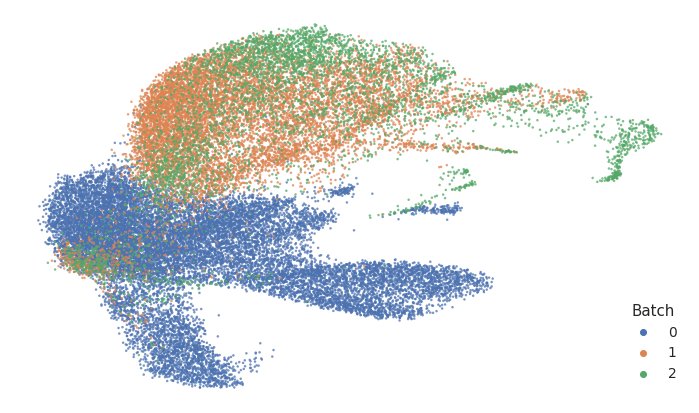

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=rf.obsm['X_umap'][:,0],
                y=rf.obsm['X_umap'][:,1],
                hue=rf.obs.batch,
                edgecolor='none',
                linewidth=0,
                alpha=.75,
                s = 200000/rf.shape[0],
                rasterized=True,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,0.05),frameon=False, title='Batch')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/supplements/batch_umap_rf.pdf',
            transparent=True)

In [32]:
del rf
gc.collect()

34025

## Weinreb

In [64]:
weinreb = sc.read('/data/bharris/single_cell_data/weinreb/weinreb_all_raw.loom')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [65]:
sc.pp.normalize_total(weinreb,target_sum=1e5)
sc.pp.log1p(weinreb)
sc.pp.highly_variable_genes(weinreb,flavor='seurat')
sc.pp.pca(weinreb)
sc.pp.neighbors(weinreb)
sc.tl.umap(weinreb)

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:37)


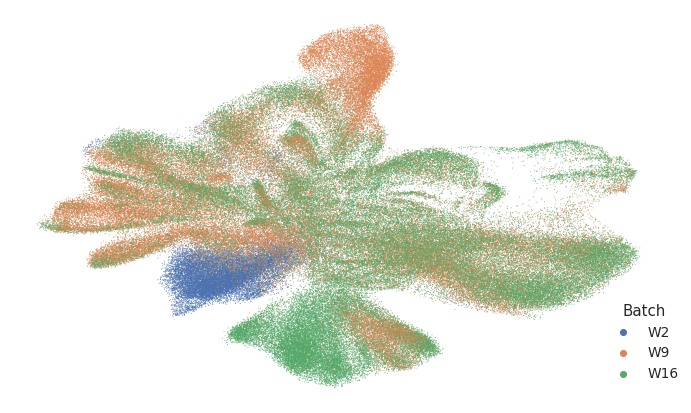

In [66]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x=weinreb.obsm['X_umap'][:,0],
                y=weinreb.obsm['X_umap'][:,1],
                hue=[f'W{t}' for t in weinreb.obs['Time point']],
                edgecolor='none',
                linewidth=0,
                alpha=.75,
                s = 200000/weinreb.shape[0],
                rasterized=True,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,0.05),frameon=False, title='Batch')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/supplements/batch_umap_weinreb.pdf',
            transparent=True)

In [38]:
del weinreb
gc.collect()

38664

## Tusi

In [56]:
tusi = sc.read('/data/bharris/single_cell_data/tusi/tusi_raw.loom')
tusi.obs.head()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


,Cell Type,PBA_Potential,PBA_Prob_Ba,PBA_Prob_D,PBA_Prob_E,PBA_Prob_GN,PBA_Prob_Ly,PBA_Prob_M,PBA_Prob_Meg,SPRING_x,SPRING_y,barcode,library_id,log1p_n_genes_by_counts,log1p_total_counts,n_genes_by_counts,pass_filter,seq_run_id,total_counts
bBM1,GN,18.431,5.807000e-06,2.651800e-04,2.713900e-05,0.99954,4.030800e-05,1.163400e-04,2.927800e-06,255.90,-385.59,AGAACGATT-GTTGCACG,basal_bm1,8.797851,10.429103,6619,1,seq_run1,33829.0
bBM4,GN,16.125,8.379900e-08,1.004100e-05,2.057400e-07,0.99999,3.257100e-07,1.242600e-06,2.952300e-08,303.10,-498.71,AAGAACGGG-GTCTCTCT,basal_bm1,8.601350,9.998298,5438,1,seq_run1,21988.0
bBM7,GN,19.285,4.788700e-05,1.885700e-03,1.921100e-04,0.99662,2.975700e-04,9.320400e-04,2.519400e-05,233.13,-316.20,ACTGCGTTG-AGAACGGG,basal_bm1,8.564649,9.887053,5242,1,seq_run1,19673.0
bBM8,GN,17.234,6.557300e-07,3.835500e-05,2.197600e-06,0.99994,4.107200e-06,1.143400e-05,2.866000e-07,281.30,-459.41,AAAAGTCGG-GCCGGATT,basal_bm1,8.482602,9.801344,4829,1,seq_run1,18057.0
bBM9,GN,10.129,8.419900e-14,1.820400e-12,1.737800e-13,1.00000,2.245800e-13,9.475200e-13,2.600200e-14,348.64,-691.98,AAGCGAAGT-GATTAGAC,basal_bm1,8.524367,9.900583,5035,1,seq_run1,19941.0


In [57]:
sc.pp.normalize_total(tusi,target_sum=1e6)
sc.pp.log1p(tusi)
sc.pp.highly_variable_genes(tusi,flavor='seurat')
sc.pp.pca(tusi)
sc.pp.neighbors(tusi)
sc.tl.umap(tusi)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


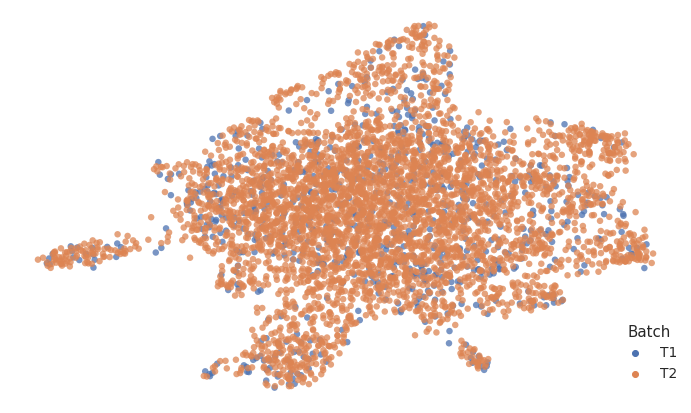

In [62]:
fig, ax = plt.subplots(figsize=(10,6))
replace_tusi = pd.Series({'seq_run1':"T1",'seq_run4':'T2'})
sns.scatterplot(x=tusi.obsm['X_umap'][:,0],
                y=tusi.obsm['X_umap'][:,1],
                hue=replace_tusi[tusi.obs['seq_run_id']],
                edgecolor='none',
                linewidth=0,
                alpha=.75,
                s = 200000/tusi.shape[0],
                rasterized=True,
                ax=ax)
ax.axis('off')
ax.legend(loc=(.9,0.05),frameon=False, title='Batch')
plt.tight_layout()
plt.savefig('/home/bharris/pseudotime/figures/supplements/batch_umap_tusi.pdf',
            transparent=True)